In [1]:
import os
import random
from datetime import datetime
import ast

import gc
import yaml
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.tensorboard import SummaryWriter

from preprocessing.final_preprocessing import serve_data, serve_data_sine

from models.transformer_encoder import TransEncoder

from ddpm.ddpm import GaussianDiffusion1D

from evaluation.pca_tsne import visual_evaluation
from evaluation.jsd import plot_jsd
from evaluation.rmse import rmse

gc.collect()

random.seed(42)
np.random.seed(42)

In [2]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# Parameters

In [3]:
config_path = "./config_transcoder.yml"
with open(config_path, 'r') as f:
    config = yaml.full_load(f)

date = datetime.today().strftime('%Y-%m-%d-%H-%M')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

seq_len = config["seq_len"]
epochs = config["epochs"]
timesteps = config["timesteps"]
batch_size_config = config["batch_size"]
latent_dim = config["latent_dim"]
num_layers = config["num_layers"]
n_heads = config["n_heads"]
beta_schedule = config["beta_schedule"]
objective = config["objective"]
model_name = config["model_name"]
cond_model = config["cond_model"]
lr = float(config["lr"])
betas = tuple_of_floats = ast.literal_eval(config["betas"])
save_rate = int(config["save_rate"])

assert model_name in ["BaseLine", "TransEncoder"], "Chosen  model was not valid, the options are BaseLine or TransEncoder"
assert cond_model in {"mlp", "te", "fft", "stft"}, "Chosen conditioning model was not valid, the options are mlp, te, fft and stft"

log_file_name = f"{model_name}_{cond_model}_{str(date)}"
tb_writer = f"./logging/tensorboard/{log_file_name}"

# Data

In [4]:
# train_loader, test_loader, features , test_data = serve_data_sine(batch_size_config, seq_len)
# cond_features = 10

In [5]:
train_loader, test_loader, train_cols, test_cols, test_data, features, cond_features = serve_data(types=["re"],seq_len=seq_len, batch_size=batch_size_config)

c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


(13129, 10, 12)


# Model

In [6]:
model = model = TransEncoder(features = features, latent_dim = latent_dim,num_heads = n_heads, num_layers = num_layers, cond_features=cond_features, cond_model=cond_model, device=device, seq_len=seq_len)
    
ddpm = GaussianDiffusion1D(model, seq_length = seq_len, timesteps = timesteps, objective = objective, loss_type = 'l2', beta_schedule = beta_schedule)
ddpm = ddpm.to(device)

optim = torch.optim.Adam(ddpm.parameters(), lr = lr, betas = betas)
writer = SummaryWriter(tb_writer)

c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


## Train

In [7]:
run_path = f"./logging/weights/{log_file_name}"
os.makedirs(run_path)

rmse_list = []
lowest_loss = 100000
step=0

for running_epoch in tqdm(range(epochs)):
    running_loss = 0.0
    for i, (data, cond_data) in enumerate(train_loader):
        data = data.to(device)
        
        cond_data = cond_data.float()
        cond_data = cond_data.to(device)
                
        batch_size = data.shape[0]
        
        optim.zero_grad()
        
        loss = ddpm(data, None)
        loss.backward()
        
        optim.step()
        
        running_loss += loss.item()

        
        if loss.item() < lowest_loss:
            lowest_loss = loss.item()
            best_model_params = model.state_dict()
        
        writer.add_scalar("Batch Training Loss", loss, global_step=step)
        step += 1
    
    avg_epoch_loss = running_loss / len(train_loader)
    writer.add_scalar("Epoch Training Loss", avg_epoch_loss, running_epoch)
    
    if running_epoch % 5 ==0:        
        with torch.no_grad():
            sample = ddpm.sample(batch_size_config)
        
        p = sample.cpu()
        q = torch.from_numpy(test_data[:batch_size_config])
            
        rmse_res = rmse(p,q).item()
        rmse_list.append(rmse_res)
        
        writer.add_scalar('Epoch Training RMSE', rmse_res, running_epoch)
        
        print(f'Epoch: {running_epoch+1}, Epoch Loss: {avg_epoch_loss:.4f}, RMSE: {rmse_res:.4f}')
    
    else:
        print(f'Epoch: {running_epoch+1}, Epoch Loss: {avg_epoch_loss:.4f}')
            
            
    if running_epoch % save_rate == 0:
        torch.save({
            'epoch': running_epoch+1,
            'diffusion_state_dict': ddpm.state_dict(),
            'diffusion_optim_state_dict': optim.state_dict()
            }, os.path.join(f'{run_path}', f'ep_{running_epoch}_mse_{avg_epoch_loss:.3f}_weights.pth'))

torch.save(best_model_params, os.path.join(f'{run_path}', 'best_model_weights.pth'))

  1%|          | 1/100 [00:06<10:48,  6.55s/it]

Epoch: 1, Epoch Loss: 0.5987, RMSE: 0.6246


  2%|▏         | 2/100 [00:07<05:21,  3.28s/it]

Epoch: 2, Epoch Loss: 0.3789


  3%|▎         | 3/100 [00:08<03:37,  2.24s/it]

Epoch: 3, Epoch Loss: 0.3454


  4%|▍         | 4/100 [00:09<02:48,  1.76s/it]

Epoch: 4, Epoch Loss: 0.3240


  5%|▌         | 5/100 [00:10<02:20,  1.48s/it]

Epoch: 5, Epoch Loss: 0.3138


  6%|▌         | 6/100 [00:16<04:49,  3.07s/it]

Epoch: 6, Epoch Loss: 0.2969, RMSE: 0.5919


  7%|▋         | 7/100 [00:17<03:42,  2.39s/it]

Epoch: 7, Epoch Loss: 0.2807


  8%|▊         | 8/100 [00:18<02:59,  1.95s/it]

Epoch: 8, Epoch Loss: 0.2779


  9%|▉         | 9/100 [00:19<02:29,  1.64s/it]

Epoch: 9, Epoch Loss: 0.2684


 10%|█         | 10/100 [00:20<02:09,  1.44s/it]

Epoch: 10, Epoch Loss: 0.2619


 11%|█         | 11/100 [00:26<04:15,  2.87s/it]

Epoch: 11, Epoch Loss: 0.2603, RMSE: 0.5938


 12%|█▏        | 12/100 [00:27<03:22,  2.30s/it]

Epoch: 12, Epoch Loss: 0.2571


 13%|█▎        | 13/100 [00:28<02:45,  1.90s/it]

Epoch: 13, Epoch Loss: 0.2489


 14%|█▍        | 14/100 [00:29<02:19,  1.62s/it]

Epoch: 14, Epoch Loss: 0.2537


 15%|█▌        | 15/100 [00:30<02:01,  1.43s/it]

Epoch: 15, Epoch Loss: 0.2470


 16%|█▌        | 16/100 [00:36<03:58,  2.84s/it]

Epoch: 16, Epoch Loss: 0.2436, RMSE: 0.5946


 17%|█▋        | 17/100 [00:37<03:09,  2.28s/it]

Epoch: 17, Epoch Loss: 0.2426


 18%|█▊        | 18/100 [00:38<02:35,  1.89s/it]

Epoch: 18, Epoch Loss: 0.2416


 19%|█▉        | 19/100 [00:39<02:11,  1.62s/it]

Epoch: 19, Epoch Loss: 0.2394


 20%|██        | 20/100 [00:40<01:54,  1.43s/it]

Epoch: 20, Epoch Loss: 0.2386


 21%|██        | 21/100 [00:46<03:44,  2.85s/it]

Epoch: 21, Epoch Loss: 0.2357, RMSE: 0.5902


 22%|██▏       | 22/100 [00:47<02:58,  2.29s/it]

Epoch: 22, Epoch Loss: 0.2366


 23%|██▎       | 23/100 [00:48<02:25,  1.89s/it]

Epoch: 23, Epoch Loss: 0.2371


 24%|██▍       | 24/100 [00:49<02:02,  1.62s/it]

Epoch: 24, Epoch Loss: 0.2377


 25%|██▌       | 25/100 [00:50<01:46,  1.42s/it]

Epoch: 25, Epoch Loss: 0.2323


 26%|██▌       | 26/100 [00:56<03:30,  2.85s/it]

Epoch: 26, Epoch Loss: 0.2347, RMSE: 0.5773


 27%|██▋       | 27/100 [00:57<02:47,  2.29s/it]

Epoch: 27, Epoch Loss: 0.2311


 28%|██▊       | 28/100 [00:58<02:16,  1.90s/it]

Epoch: 28, Epoch Loss: 0.2289


 29%|██▉       | 29/100 [00:59<01:55,  1.62s/it]

Epoch: 29, Epoch Loss: 0.2306


 30%|███       | 30/100 [01:00<01:40,  1.43s/it]

Epoch: 30, Epoch Loss: 0.2314


 31%|███       | 31/100 [01:07<03:17,  2.86s/it]

Epoch: 31, Epoch Loss: 0.2289, RMSE: 0.5917


 32%|███▏      | 32/100 [01:08<02:36,  2.30s/it]

Epoch: 32, Epoch Loss: 0.2290


 33%|███▎      | 33/100 [01:09<02:08,  1.92s/it]

Epoch: 33, Epoch Loss: 0.2265


 34%|███▍      | 34/100 [01:10<01:49,  1.65s/it]

Epoch: 34, Epoch Loss: 0.2279


 35%|███▌      | 35/100 [01:11<01:34,  1.46s/it]

Epoch: 35, Epoch Loss: 0.2270


 36%|███▌      | 36/100 [01:17<03:05,  2.90s/it]

Epoch: 36, Epoch Loss: 0.2304, RMSE: 0.5837


 37%|███▋      | 37/100 [01:18<02:26,  2.33s/it]

Epoch: 37, Epoch Loss: 0.2278


 38%|███▊      | 38/100 [01:19<01:59,  1.92s/it]

Epoch: 38, Epoch Loss: 0.2284


 39%|███▉      | 39/100 [01:20<01:40,  1.64s/it]

Epoch: 39, Epoch Loss: 0.2247


 40%|████      | 40/100 [01:21<01:26,  1.45s/it]

Epoch: 40, Epoch Loss: 0.2253


 41%|████      | 41/100 [01:27<02:50,  2.89s/it]

Epoch: 41, Epoch Loss: 0.2241, RMSE: 0.5862


 42%|████▏     | 42/100 [01:28<02:14,  2.32s/it]

Epoch: 42, Epoch Loss: 0.2209


 43%|████▎     | 43/100 [01:29<01:49,  1.92s/it]

Epoch: 43, Epoch Loss: 0.2236


 44%|████▍     | 44/100 [01:30<01:32,  1.65s/it]

Epoch: 44, Epoch Loss: 0.2245


 45%|████▌     | 45/100 [01:31<01:20,  1.46s/it]

Epoch: 45, Epoch Loss: 0.2226


 46%|████▌     | 46/100 [01:37<02:37,  2.92s/it]

Epoch: 46, Epoch Loss: 0.2223, RMSE: 0.5776


 47%|████▋     | 47/100 [01:38<02:04,  2.35s/it]

Epoch: 47, Epoch Loss: 0.2206


 48%|████▊     | 48/100 [01:40<01:41,  1.95s/it]

Epoch: 48, Epoch Loss: 0.2215


 49%|████▉     | 49/100 [01:41<01:24,  1.67s/it]

Epoch: 49, Epoch Loss: 0.2218


 50%|█████     | 50/100 [01:42<01:13,  1.47s/it]

Epoch: 50, Epoch Loss: 0.2206


 51%|█████     | 51/100 [01:48<02:22,  2.92s/it]

Epoch: 51, Epoch Loss: 0.2208, RMSE: 0.5873


 52%|█████▏    | 52/100 [01:49<01:52,  2.34s/it]

Epoch: 52, Epoch Loss: 0.2210


 53%|█████▎    | 53/100 [01:50<01:31,  1.94s/it]

Epoch: 53, Epoch Loss: 0.2169


 54%|█████▍    | 54/100 [01:51<01:16,  1.65s/it]

Epoch: 54, Epoch Loss: 0.2158


 55%|█████▌    | 55/100 [01:52<01:05,  1.46s/it]

Epoch: 55, Epoch Loss: 0.2212


 56%|█████▌    | 56/100 [01:58<02:08,  2.93s/it]

Epoch: 56, Epoch Loss: 0.2200, RMSE: 0.6019


 57%|█████▋    | 57/100 [01:59<01:41,  2.35s/it]

Epoch: 57, Epoch Loss: 0.2211


 58%|█████▊    | 58/100 [02:00<01:21,  1.94s/it]

Epoch: 58, Epoch Loss: 0.2194


 59%|█████▉    | 59/100 [02:01<01:07,  1.66s/it]

Epoch: 59, Epoch Loss: 0.2198


 60%|██████    | 60/100 [02:02<00:58,  1.46s/it]

Epoch: 60, Epoch Loss: 0.2164


 61%|██████    | 61/100 [02:08<01:52,  2.89s/it]

Epoch: 61, Epoch Loss: 0.2167, RMSE: 0.5887


 62%|██████▏   | 62/100 [02:09<01:28,  2.33s/it]

Epoch: 62, Epoch Loss: 0.2180


 63%|██████▎   | 63/100 [02:10<01:11,  1.93s/it]

Epoch: 63, Epoch Loss: 0.2168


 64%|██████▍   | 64/100 [02:11<00:59,  1.65s/it]

Epoch: 64, Epoch Loss: 0.2144


 65%|██████▌   | 65/100 [02:12<00:51,  1.46s/it]

Epoch: 65, Epoch Loss: 0.2169


 66%|██████▌   | 66/100 [02:19<01:39,  2.93s/it]

Epoch: 66, Epoch Loss: 0.2161, RMSE: 0.5741


 67%|██████▋   | 67/100 [02:20<01:17,  2.36s/it]

Epoch: 67, Epoch Loss: 0.2164


 68%|██████▊   | 68/100 [02:21<01:02,  1.96s/it]

Epoch: 68, Epoch Loss: 0.2163


 69%|██████▉   | 69/100 [02:22<00:51,  1.67s/it]

Epoch: 69, Epoch Loss: 0.2162


 70%|███████   | 70/100 [02:23<00:44,  1.48s/it]

Epoch: 70, Epoch Loss: 0.2173


 71%|███████   | 71/100 [02:29<01:25,  2.94s/it]

Epoch: 71, Epoch Loss: 0.2177, RMSE: 0.5824


 72%|███████▏  | 72/100 [02:30<01:05,  2.36s/it]

Epoch: 72, Epoch Loss: 0.2179


 73%|███████▎  | 73/100 [02:31<00:52,  1.95s/it]

Epoch: 73, Epoch Loss: 0.2155


 74%|███████▍  | 74/100 [02:32<00:43,  1.66s/it]

Epoch: 74, Epoch Loss: 0.2175


 75%|███████▌  | 75/100 [02:33<00:36,  1.46s/it]

Epoch: 75, Epoch Loss: 0.2163


 76%|███████▌  | 76/100 [02:39<01:09,  2.88s/it]

Epoch: 76, Epoch Loss: 0.2143, RMSE: 0.5749


 77%|███████▋  | 77/100 [02:40<00:53,  2.32s/it]

Epoch: 77, Epoch Loss: 0.2182


 78%|███████▊  | 78/100 [02:41<00:42,  1.91s/it]

Epoch: 78, Epoch Loss: 0.2163


 79%|███████▉  | 79/100 [02:42<00:34,  1.63s/it]

Epoch: 79, Epoch Loss: 0.2130


 80%|████████  | 80/100 [02:43<00:28,  1.43s/it]

Epoch: 80, Epoch Loss: 0.2175


 81%|████████  | 81/100 [02:49<00:53,  2.84s/it]

Epoch: 81, Epoch Loss: 0.2141, RMSE: 0.5727


 82%|████████▏ | 82/100 [02:50<00:41,  2.28s/it]

Epoch: 82, Epoch Loss: 0.2139


 83%|████████▎ | 83/100 [02:51<00:32,  1.89s/it]

Epoch: 83, Epoch Loss: 0.2119


 84%|████████▍ | 84/100 [02:52<00:25,  1.62s/it]

Epoch: 84, Epoch Loss: 0.2094


 85%|████████▌ | 85/100 [02:53<00:21,  1.43s/it]

Epoch: 85, Epoch Loss: 0.2126


 86%|████████▌ | 86/100 [02:59<00:39,  2.84s/it]

Epoch: 86, Epoch Loss: 0.2176, RMSE: 0.5967


 87%|████████▋ | 87/100 [03:00<00:29,  2.28s/it]

Epoch: 87, Epoch Loss: 0.2127


 88%|████████▊ | 88/100 [03:01<00:22,  1.89s/it]

Epoch: 88, Epoch Loss: 0.2115


 89%|████████▉ | 89/100 [03:02<00:17,  1.62s/it]

Epoch: 89, Epoch Loss: 0.2125


 90%|█████████ | 90/100 [03:03<00:14,  1.43s/it]

Epoch: 90, Epoch Loss: 0.2138


 91%|█████████ | 91/100 [03:10<00:25,  2.88s/it]

Epoch: 91, Epoch Loss: 0.2099, RMSE: 0.5934


 92%|█████████▏| 92/100 [03:11<00:18,  2.31s/it]

Epoch: 92, Epoch Loss: 0.2119


 93%|█████████▎| 93/100 [03:12<00:13,  1.92s/it]

Epoch: 93, Epoch Loss: 0.2113


 94%|█████████▍| 94/100 [03:13<00:09,  1.64s/it]

Epoch: 94, Epoch Loss: 0.2143


 95%|█████████▌| 95/100 [03:14<00:07,  1.44s/it]

Epoch: 95, Epoch Loss: 0.2117


 96%|█████████▌| 96/100 [03:20<00:11,  2.85s/it]

Epoch: 96, Epoch Loss: 0.2106, RMSE: 0.5876


 97%|█████████▋| 97/100 [03:21<00:06,  2.29s/it]

Epoch: 97, Epoch Loss: 0.2110


 98%|█████████▊| 98/100 [03:22<00:03,  1.90s/it]

Epoch: 98, Epoch Loss: 0.2139


 99%|█████████▉| 99/100 [03:23<00:01,  1.63s/it]

Epoch: 99, Epoch Loss: 0.2104


100%|██████████| 100/100 [03:24<00:00,  2.04s/it]

Epoch: 100, Epoch Loss: 0.2099


In [8]:
model.load_state_dict(torch.load(os.path.join(f'{run_path}', 'best_model_weights.pth')))
ddpm = GaussianDiffusion1D(model, seq_length = seq_len, timesteps = timesteps, objective = objective, loss_type = 'l2', beta_schedule = beta_schedule)
ddpm = ddpm.to(device)

C:\Users\Arne\AppData\Local\Temp\ipykernel_31528\1081204139.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(f'{run_path}', 

## Sampling

In [9]:
with torch.no_grad():
    samples = ddpm.sample(batch_size_config)
    samples = samples.cpu().numpy()

print(f"Samples shape: {samples.shape}")

sampling loop time step: 100%|██████████| 1000/1000 [00:05<00:00, 191.01it/s]

Samples shape: (256, 10, 12)


# Evaluation
## Without Conditioning
### Train

In [10]:
real_data_train, real_cond_data_train = next(iter(train_loader))
real_data_test, real_cond_data_test = next(iter(test_loader))

real_cond_data_train.shape, real_data_test.shape

(torch.Size([256, 10, 12]), torch.Size([256, 10, 12]))

c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


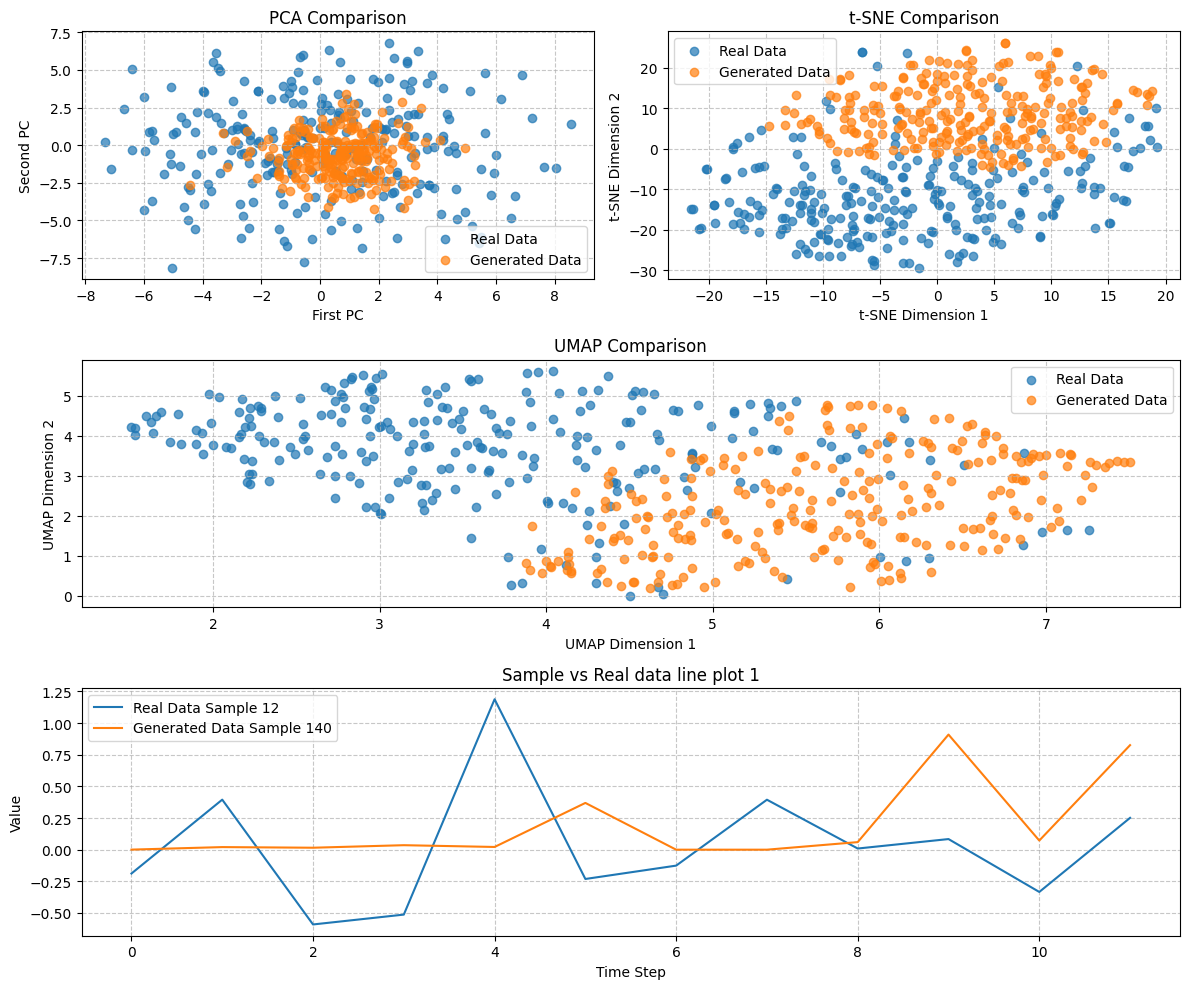

In [11]:
visual_evaluation(real_data_train, samples, log_file_name, False, "train")

### Test

c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


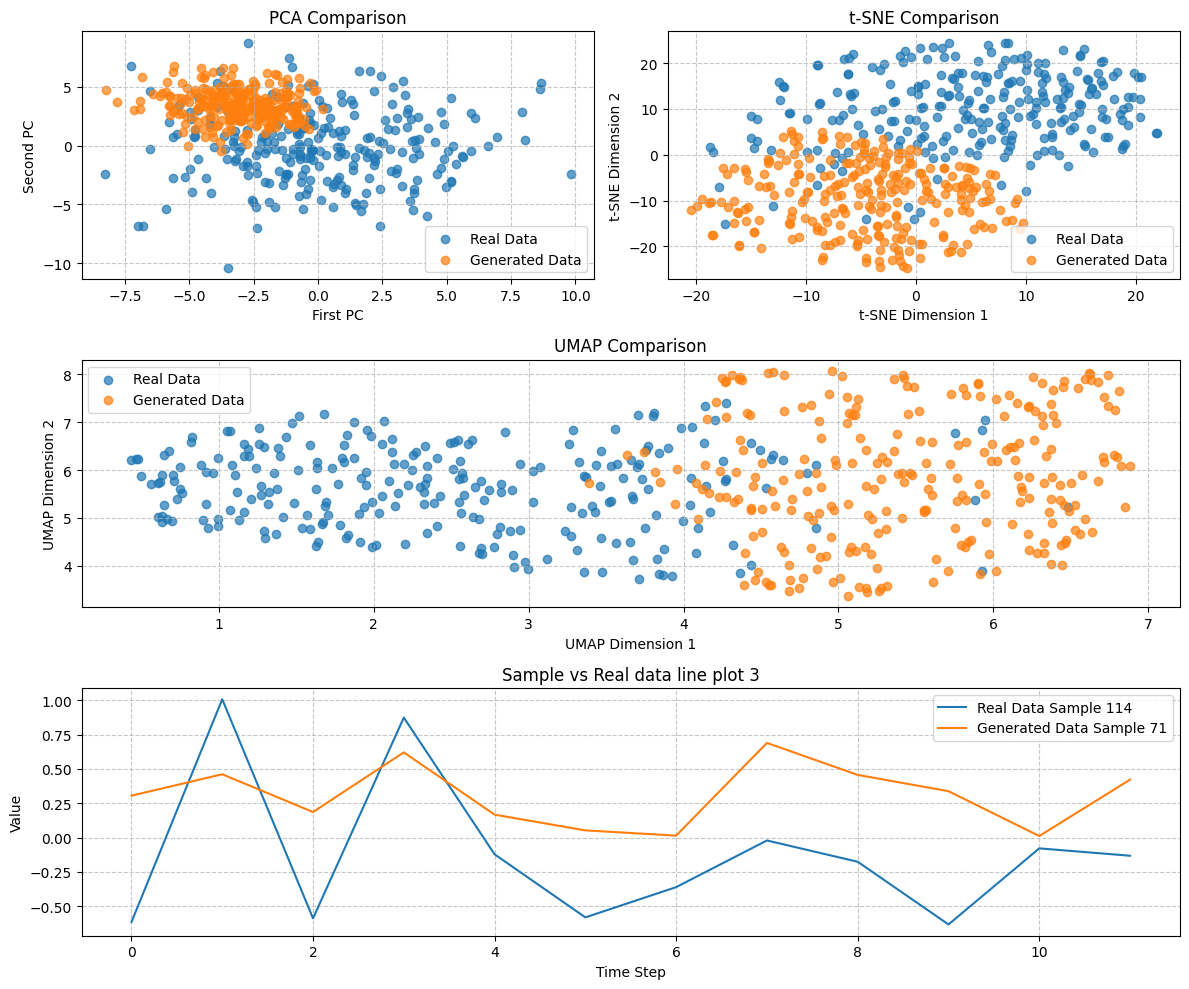

In [12]:
visual_evaluation(real_data_test, samples, log_file_name, False, "test")

### Jensen-Shannon Divergence

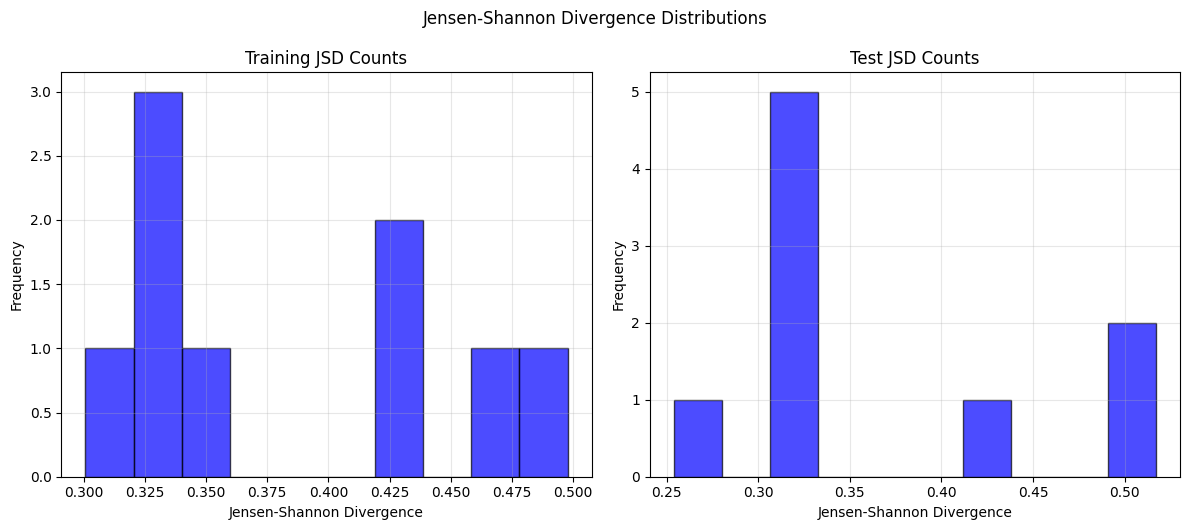

In [13]:
plot_jsd(real_data_train, real_data_test, samples.transpose(0,2,1), log_file_name)

### Plot Comparison

sampling loop time step: 100%|██████████| 1000/1000 [00:03<00:00, 288.83it/s]


Text(0.5, 1.0, 'Real Data')

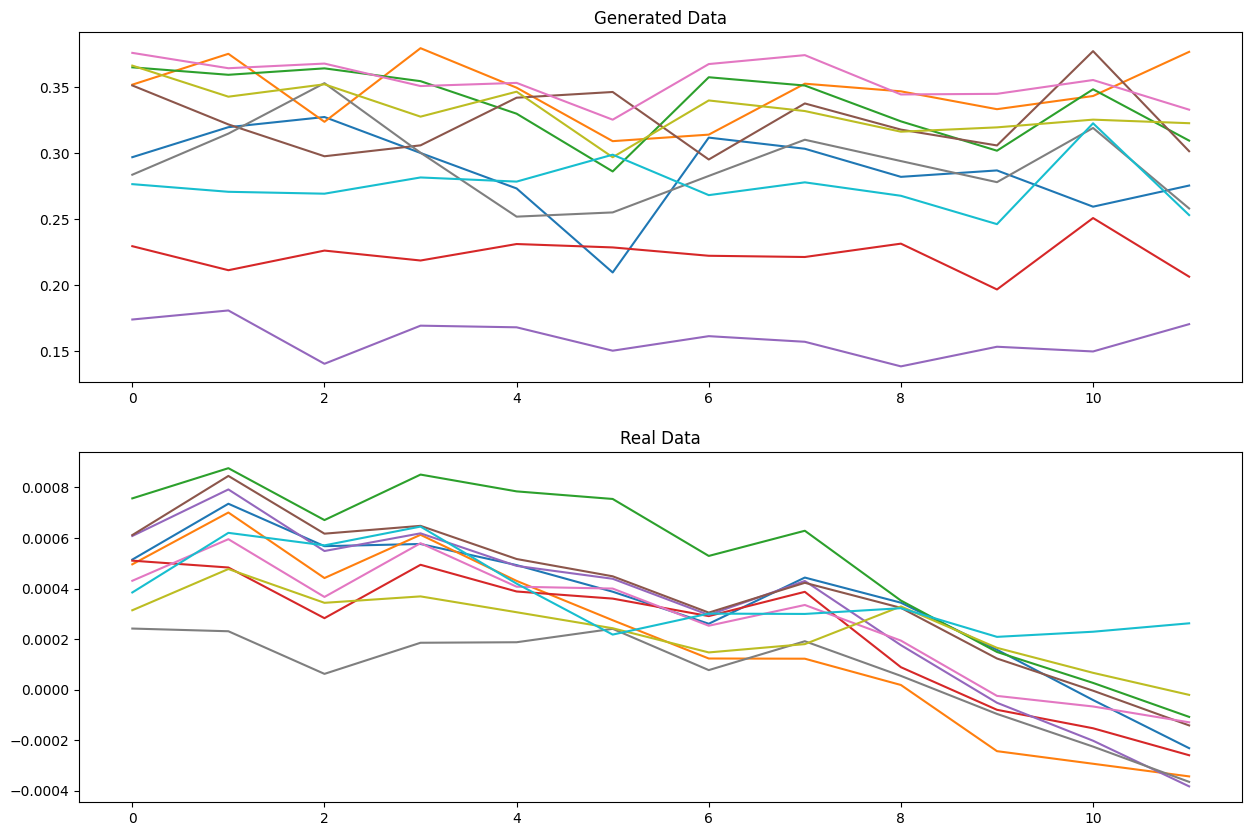

In [14]:
sample_list = []
for i in range(0, 100):
    with torch.no_grad():
        sample = ddpm.sample(1)
        sample = sample.cpu().numpy().squeeze()
    
    sample_list.append(sample)

sample_mean = np.mean(sample_list, axis=0)
gt_mean = test_data.mean(axis=0)

fig, axs = plt.subplots(2, 1, figsize=(15, 10))

for i in range(0, sample_mean.shape[0]):
    axs[0].plot(range(0, sample_mean.shape[1]), sample_mean[i])
    axs[1].plot(range(0, gt_mean.shape[1]), gt_mean[i])

axs[0].set_title("Generated Data")
axs[1].set_title("Real Data")


## With Conditioning

In [15]:
with torch.no_grad():
    cond_samples_train = ddpm.sample(real_cond_data_train.shape[0], real_cond_data_train.to(device))
    cond_samples_train = cond_samples_train.cpu().numpy()

print(f"Samples shape: {cond_samples_train.shape}")

sampling loop time step: 100%|██████████| 1000/1000 [00:05<00:00, 185.22it/s]

Samples shape: (256, 10, 12)


## Train

### T-SNE and PCA

c:\Users\Arne\anaconda3\envs\hf_diff\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


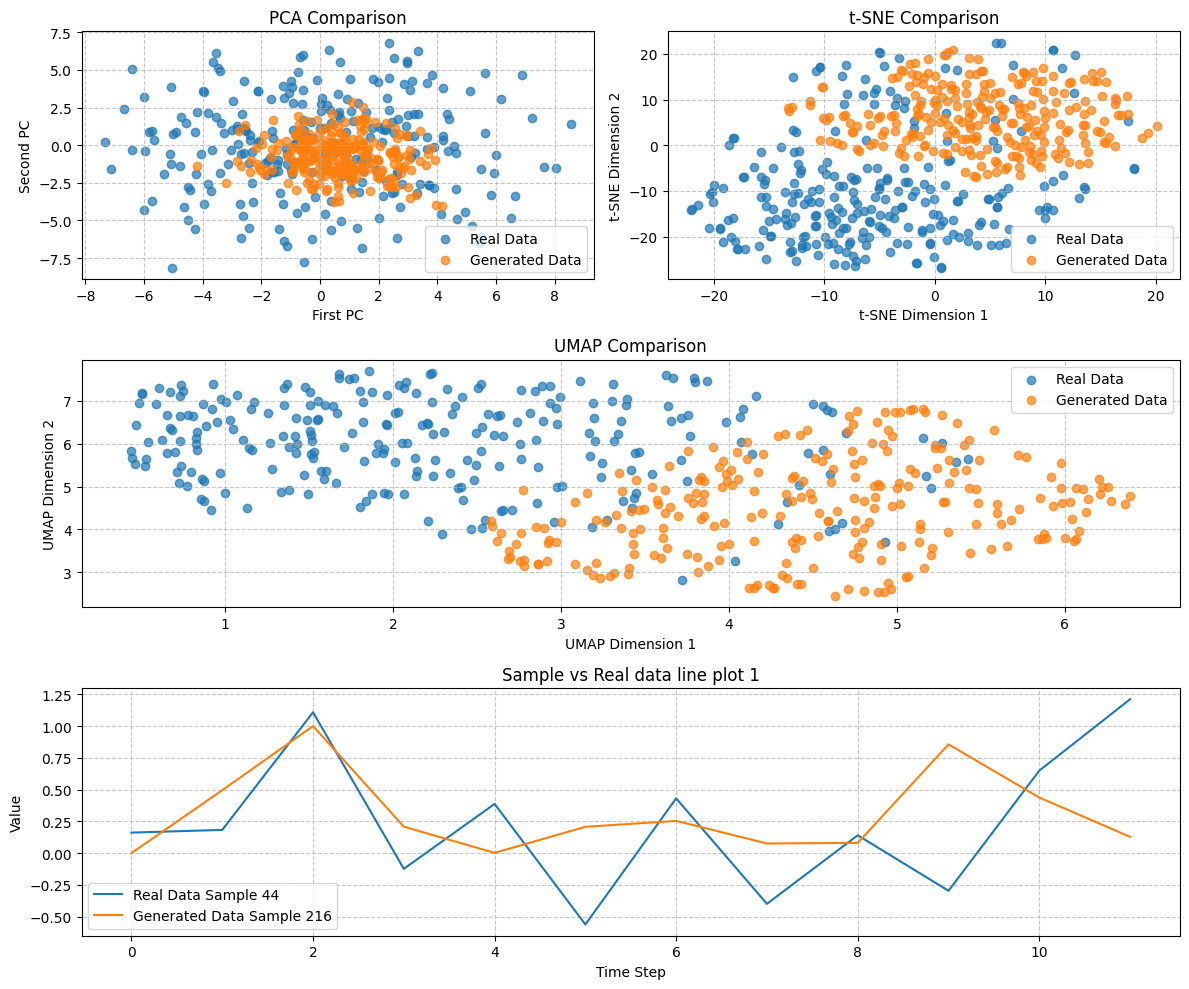

In [16]:
visual_evaluation(real_data_train, cond_samples_train, log_file_name, True, "train")

### Jensen-Shannon-Divergence

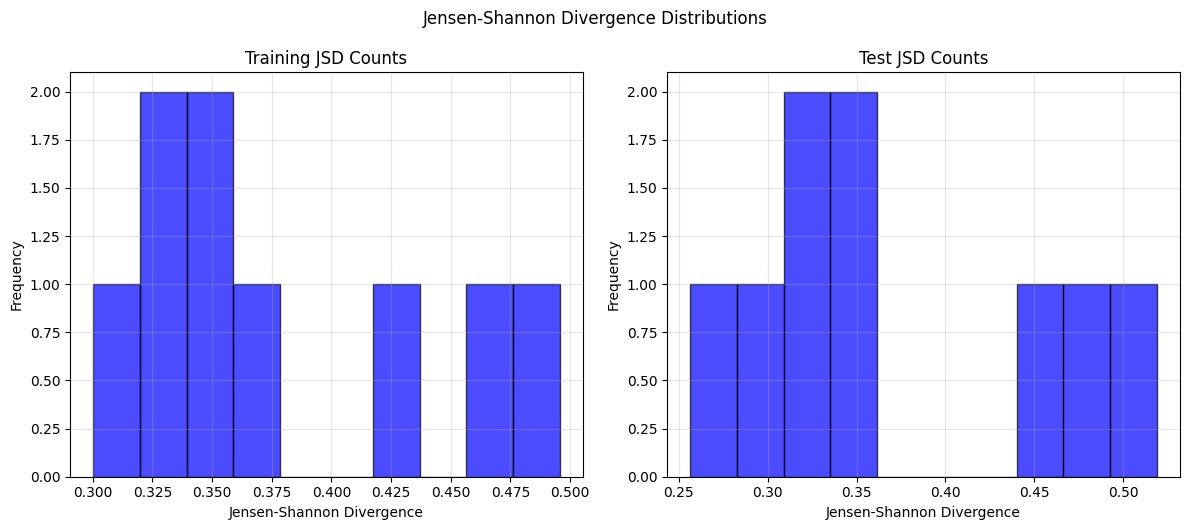

In [17]:
plot_jsd(real_data_train, real_data_test, cond_samples_train.transpose(0,2,1), log_file_name, cond=True)

## Test

In [18]:
with torch.no_grad():
    cond_samples_test = ddpm.sample(real_cond_data_test.shape[0], real_cond_data_test.to(device))
    cond_samples_test = cond_samples_test.cpu().numpy()

print(f"Samples shape: {cond_samples_test.shape}")

sampling loop time step:  16%|█▌        | 157/1000 [00:00<00:05, 162.70it/s]


KeyboardInterrupt: 

In [ ]:
visual_evaluation(real_data_test, cond_samples_test, log_file_name, True, "test")

### Jensen-Shannon Divergence

In [ ]:
plot_jsd(real_data_train, real_data_test, cond_samples_test.transpose(0,2,1), log_file_name, cond=True)

# Logging

In [ ]:
log_dir = "./logging/logs"
log_file_path = os.path.join(log_dir, log_file_name + ".txt")

with open(log_file_path, 'w') as log_file:
    log_file.write("Config:\n")
    for key, value in config.items():
        log_file.write(f"{key}: {value}\n")
    
    log_file.write("\n\nRMSE Values:\n")
    for rmse in rmse_list:
        log_file.write(f"{rmse}\n")

print(f"Log file created at: {log_file_path}")